In [1]:
import torch
import numpy as np

In [2]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

In [3]:
import os, sys

## Data

In [4]:
def hamiltonian_fn(coords): # input coords of form (q, p) -- (where q = q*sqrt(k/2) and p = p*sqrt(1/2m)
    q, p = np.split(coords,2) 
    H = p**2 + q**2 # Hamiltonian of a spring
    return H

In [5]:
def dynamics_fn(t, coords): # returns dq/dt (=dH/dp) and dp/dt (=-dH/dq)
    dcoords = autograd.grad(hamiltonian_fn)(coords)
    dhdq, dhdp = np.split(dcoords,2)
    S = np.concatenate([dhdp, -dhdq], axis=-1)
    return S

In [6]:
def get_trajectory(t_span=[0,3], timescale=10, radius=None, y0=None, noise_std=0.1, **kwargs):
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))
    
    # get initial state
    if y0 is None:
        y0 = np.random.rand(2)*2-1
    if radius is None:
        radius = np.random.rand()*0.9 + 0.1 # sample a range of radii
    y0 = y0 / np.sqrt((y0**2).sum()) * radius ## set the appropriate radius

    spring_ivp = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10, **kwargs)
    q, p = spring_ivp['y'][0], spring_ivp['y'][1]
    dydt = [dynamics_fn(None, y) for y in spring_ivp['y'].T]
    dydt = np.stack(dydt).T
    dqdt, dpdt = np.split(dydt,2)
    
    # add noise
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, t_eval

Text(0, 0.5, 'dp/dt')

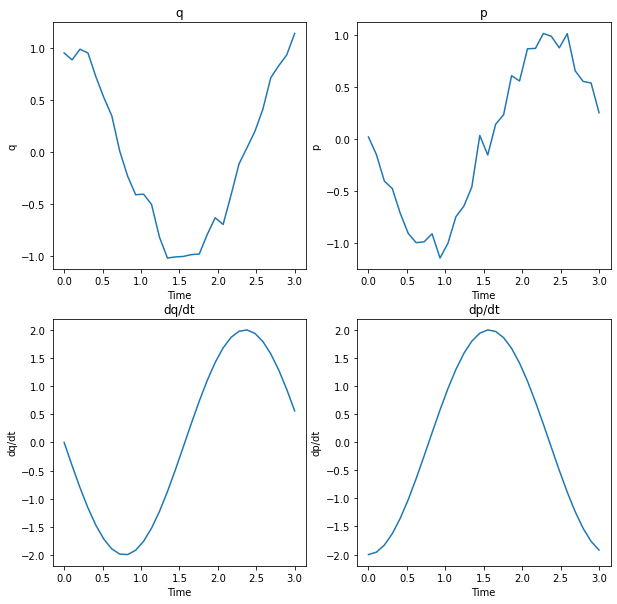

In [7]:
fig, ax = plt.subplots(2, 2, figsize = [10, 10])

ax[0,0].plot(np.linspace(0, 3, 30), get_trajectory(y0 = np.array([1,0]), radius = 1)[0])
ax[0,0].set_title('q')
ax[0,0].set_xlabel('Time')
ax[0,0].set_ylabel('q')
ax[0,1].plot(np.linspace(0, 3, 30), get_trajectory(y0 = np.array([1,0]), radius = 1)[1])
ax[0,1].set_title('p')
ax[0,1].set_xlabel('Time')
ax[0,1].set_ylabel('p')
ax[1,0].plot(np.linspace(0, 3, 30), get_trajectory(y0 = np.array([1,0]), radius = 1)[2][0])
ax[1,0].set_title('dq/dt')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('dq/dt')
ax[1,1].plot(np.linspace(0, 3, 30), get_trajectory(y0 = np.array([1,0]), radius = 1)[3][0])
ax[1,1].set_title('dp/dt')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('dp/dt')

In [11]:
def get_dataset(seed=0, samples=50, test_split=0.5, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        x, y, dx, dy, t = get_trajectory(**kwargs)
        xs.append( np.stack( [x, y]).T )
        dxs.append( np.stack( [dx, dy]).T )
        
    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

def get_field(xmin=-1.2, xmax=1.2, ymin=-1.2, ymax=1.2, gridsize=20):
    field = {'meta': locals()}

    # meshgrid to get vector field
    b, a = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    ys = np.stack([b.flatten(), a.flatten()])
    
    # get vector directions
    dydt = [dynamics_fn(None, y) for y in ys.T]
    dydt = np.stack(dydt).T

    field['x'] = ys.T
    field['dx'] = dydt.T
    return field

In [12]:
def rk4(fun, y0, t, dt, *args, **kwargs): # Runge-Kutta Fourth Order Integration
    # y0 = initial state, t = initial time, dt = time step
    dt2 = dt / 2.0
    k1 = fun(y0, t, *args, **kwargs)
    k2 = fun(y0 + dt2 * k1, t + dt2, *args, **kwargs)
    k3 = fun(y0 + dt2 * k2, t + dt2, *args, **kwargs)
    k4 = fun(y0 + dt * k3, t + dt, *args, **kwargs)
    dy = dt / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)
    return dy

In [154]:
class MLP(torch.nn.Module): # Multi-layer perceptron (just neural network with multiple layers, nonlinear activation function)
    def __init__(self, input_dim, hidden_dim, output_dim, nonlinearity=torch.tanh):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = torch.nn.Linear(hidden_dim, output_dim, bias=None)

        for l in [self.linear1, self.linear2, self.linear3]:
            torch.nn.init.orthogonal_(l.weight) # semi-orthogonal initial parameters
        self.nonlinearity = nonlinearity

    def forward(self, x, separate_fields=False):
        h = self.nonlinearity( self.linear1(x) )
        h = self.nonlinearity( self.linear2(h) )
        return self.linear3(h)

In [155]:
class HNN(torch.nn.Module):
    def __init__(self, input_dim, differentiable_model, field_type='solenoidal',
                    baseline=False, assume_canonical_coords=True):
        super(HNN, self).__init__()
        self.baseline = baseline # Use baseline model or not (default is False)
        self.differentiable_model = differentiable_model # The differentiable model will be the MLP
        self.assume_canonical_coords = assume_canonical_coords
        self.M = self.permutation_tensor(input_dim) # Levi-Civita permutation tensor
        self.field_type = field_type

    def forward(self, x):
        if self.baseline: # if using baseline model (non-Hamiltonian model)
            return self.differentiable_model(x)

        y = self.differentiable_model(x)
        assert y.dim() == 2 and y.shape[1] == 2, "Output tensor should have shape [batch_size, 2]"
        return y.split(1,1)

    def rk4_time_derivative(self, x, dt):
        return rk4(fun=self.time_derivative, y0=x, t=0, dt=dt)

    def time_derivative(self, x, t=None, separate_fields=False):
        '''NEURAL ODE-STLE VECTOR FIELD'''
        if self.baseline:
            return self.differentiable_model(x)

        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''
        F1, F2 = self.forward(x) # traditional forward pass

        conservative_field = torch.zeros_like(x) # start out with both components set to 0
        solenoidal_field = torch.zeros_like(x)

        if self.field_type != 'solenoidal':
            dF1 = torch.autograd.grad(F1.sum(), x, create_graph=True)[0] # gradients for conservative field
            conservative_field = dF1 @ torch.eye(*self.M.shape)

        if self.field_type != 'conservative':
            dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] # gradients for solenoidal field
            solenoidal_field = dF2 @ self.M.t()

        if separate_fields:
            return [conservative_field, solenoidal_field]

        return conservative_field + solenoidal_field

    def permutation_tensor(self,n):
        M = None
        if self.assume_canonical_coords:
            M = torch.eye(n)
            M = torch.cat([M[n//2:], -M[:n//2]])
        else:
            '''Constructs the Levi-Civita permutation tensor'''
            M = torch.ones(n,n) # matrix of ones
            M *= 1 - torch.eye(n) # clear diagonals
            M[::2] *= -1 # pattern of signs
            M[:,::2] *= -1
    
            for i in range(n): # make asymmetric
                for j in range(i+1, n):
                    M[i,j] *= -1
        return M

In [156]:
def L2_loss(u, v): # mean-square error
    return (u-v).pow(2).mean()

### (Sanity Check that predicted hamiltonian is close to actual)

In [110]:
f1, f2 = model(x)

In [94]:
x2 = x.cpu().detach().numpy()
hampred = f2.cpu().detach().numpy()

In [105]:
real_hamiltonian = np.array([hamiltonian_fn(l) for l in x2])
real_hamiltonian = real_hamiltonian.flatten()

In [106]:
p = np.polyfit(real_hamiltonian, hampred, 1)

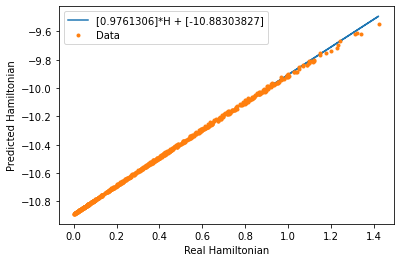

In [108]:
plt.plot(real_hamiltonian, p[0]*real_hamiltonian + p[1], label = f'{p[0]}*H + {p[1]}')
plt.plot(real_hamiltonian, hampred, '.', label = 'Data')
plt.xlabel('Real Hamiltonian')
plt.ylabel('Predicted Hamiltonian')
plt.legend()

In [93]:
x = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32)
print(x)

tensor([[-0.0847,  0.8053],
        [ 0.4012,  0.5271],
        [ 0.2978,  0.5341],
        ...,
        [-0.7869,  0.1583],
        [-0.5100,  0.4694],
        [-0.8953,  0.3002]], requires_grad=True)


In [111]:
torch.autograd.grad(f2.sum(), x, create_graph=True)

(tensor([[-0.1781,  1.5541],
         [ 0.7908,  1.0591],
         [ 0.5879,  1.0764],
         ...,
         [-1.4959,  0.3215],
         [-0.9963,  0.9524],
         [-1.6532,  0.5920]], grad_fn=<MmBackward0>),)

In [112]:
realdts = np.array([dynamics_fn(None, l) for l in x2])

In [146]:
realdts

array([[ 1.6106344 ,  0.16940421],
       [ 1.0541147 , -0.8023327 ],
       [ 1.0681553 , -0.5955942 ],
       ...,
       [ 0.31655896,  1.5737389 ],
       [ 0.93874514,  1.0199623 ],
       [ 0.60049176,  1.7905734 ]], dtype=float32)

### Training

In [15]:
input_dim = 2 # input tensor dimension
hidden_dim = 200 # hidden dimension of mlp
l_rate = 1e-3 # initial learning rate
nonlinearity = torch.tanh # mlp non-linear activation function
total_steps = 2000 # number of gradient steps
print_every = 200 # gradient steps between printing
baseline = False # run baseline (not HNN)
verbose = True # print stuff
use_rk4 = False # integrate derivatives with RK4
field_type = 'solenoidal' # type of vector field to learn (solenoidal/divergenceless Hamiltonian vector field)
seed = 0 # random seed

def train():
    # set random seed
    torch.manual_seed(0)
    np.random.seed(0)

    # init model and optimizer
    if verbose:
        print("Training baseline model:" if baseline else "Training HNN model:")

    output_dim = input_dim if baseline else 2
    nn_model = MLP(input_dim, hidden_dim, output_dim, nonlinearity)
    model = HNN(input_dim, differentiable_model=nn_model,
                  field_type=field_type, baseline=baseline)
    optim = torch.optim.Adam(model.parameters(), l_rate, weight_decay=1e-4)

    # arrange data
    data = get_dataset(seed=seed)
    x = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32)
    test_x = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.Tensor(data['dx'])
    test_dxdt = torch.Tensor(data['test_dx'])

    # vanilla train loop
    stats = {'train_loss': [], 'test_loss': []}
    for step in range(total_steps+1):
    
        # train step
        dxdt_hat = model.rk4_time_derivative(x) if use_rk4 else model.time_derivative(x)
        loss = L2_loss(dxdt, dxdt_hat)
        loss.backward() ; optim.step() ; optim.zero_grad()

        # run test data
        test_dxdt_hat = model.rk4_time_derivative(test_x) if use_rk4 else model.time_derivative(test_x)
        test_loss = L2_loss(test_dxdt, test_dxdt_hat)

        # logging
        stats['train_loss'].append(loss.item())
        stats['test_loss'].append(test_loss.item())
        if verbose and step % print_every == 0:
            print("step {}, train_loss {:.4e}, test_loss {:.4e}".format(step, loss.item(), test_loss.item()))

    train_dxdt_hat = model.time_derivative(x)
    train_dist = (dxdt - train_dxdt_hat)**2
    test_dxdt_hat = model.time_derivative(test_x)
    test_dist = (test_dxdt - test_dxdt_hat)**2
    print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
        .format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
                test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))

    return model, stats

In [52]:
model, stats = train()

Training HNN model:
Parameter containing:
tensor([[-0.0643, -0.0398],
        [ 0.0312, -0.0445],
        [-0.0588, -0.0343],
        [-0.0782,  0.1508],
        [-0.1256,  0.0053],
        [-0.0132, -0.0489],
        [-0.0646, -0.0093],
        [-0.0047,  0.0320],
        [-0.1528, -0.0451],
        [-0.0994, -0.0195],
        [-0.0164, -0.0256],
        [-0.0203, -0.0725],
        [ 0.0721,  0.0263],
        [-0.0288, -0.0091],
        [ 0.0414,  0.0610],
        [ 0.1552, -0.0470],
        [-0.0844, -0.0131],
        [ 0.0658,  0.0630],
        [-0.0297,  0.0519],
        [-0.0432,  0.1080],
        [ 0.0731, -0.0477],
        [-0.0171,  0.0284],
        [-0.0542,  0.1060],
        [-0.0471, -0.1709],
        [ 0.0474, -0.1148],
        [ 0.0951,  0.0062],
        [ 0.0939,  0.0213],
        [-0.0717, -0.0270],
        [-0.0957,  0.0208],
        [-0.1160, -0.0425],
        [-0.1230,  0.0120],
        [-0.1333, -0.0171],
        [-0.0585, -0.0304],
        [-0.0204, -0.1266],
      

In [20]:
model_name = 'baseline' if baseline else 'hnn'
save_dir = './experiment-spring'

os.makedirs(save_dir) if not os.path.exists(save_dir) else None

path = "{}/spring{}-{}.tar".format(save_dir, RK4, model_name)
torch.save(model.state_dict(), path)

In [49]:
path

'./experiment-spring/spring-hnn.tar'

### Analyze mass-spring

In [19]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

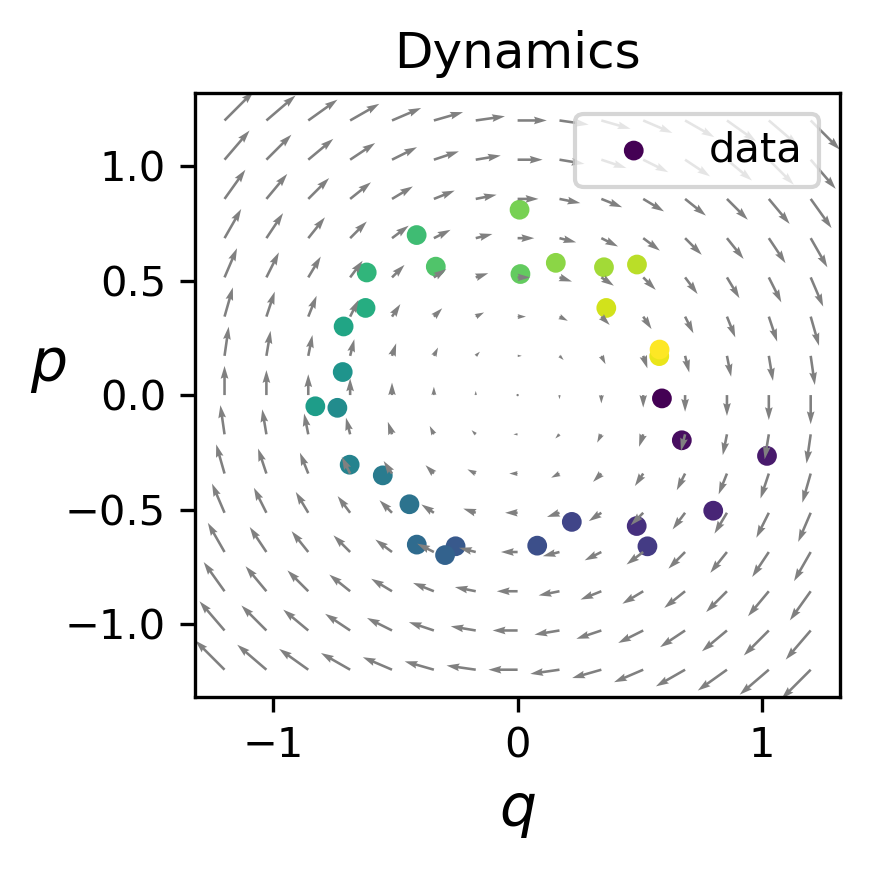

In [152]:
# args = ObjectView(get_args())
# np.random.seed(args.seed)
field = get_field(gridsize=15)
data = get_dataset()

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(radius=0.7, y0=np.array([1,0]))
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/spring-task.png')


In [21]:
def get_model(baseline):
    output_dim = input_dim if baseline else 2
    nn_model = MLP(input_dim, hidden_dim, output_dim, nonlinearity)
    model = HNN(input_dim, differentiable_model=nn_model,
              field_type=field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'hnn'
    path = "{}/spring{}-{}.tar".format(save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    return model

In [22]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor(np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

In [23]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [163]:
gridsize=10

base_model = get_model(baseline=True)
hnn_model = get_model(baseline=False)

# get their vector fields
field = get_field(gridsize=gridsize)
data = get_dataset()
base_field = get_vector_field(base_model, gridsize=gridsize)
hnn_field = get_vector_field(hnn_model, gridsize=gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,30]
y0 = np.asarray([1, 2])
radius = 1
y0 = y0 / np.sqrt((y0**2).sum()) * radius
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 2000), 'rtol': 1e-12}
base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)

In [167]:
kwargs = {'t_eval': None, 'rtol': 1e-12}
true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, **kwargs)
true_x = true_path['y'].T

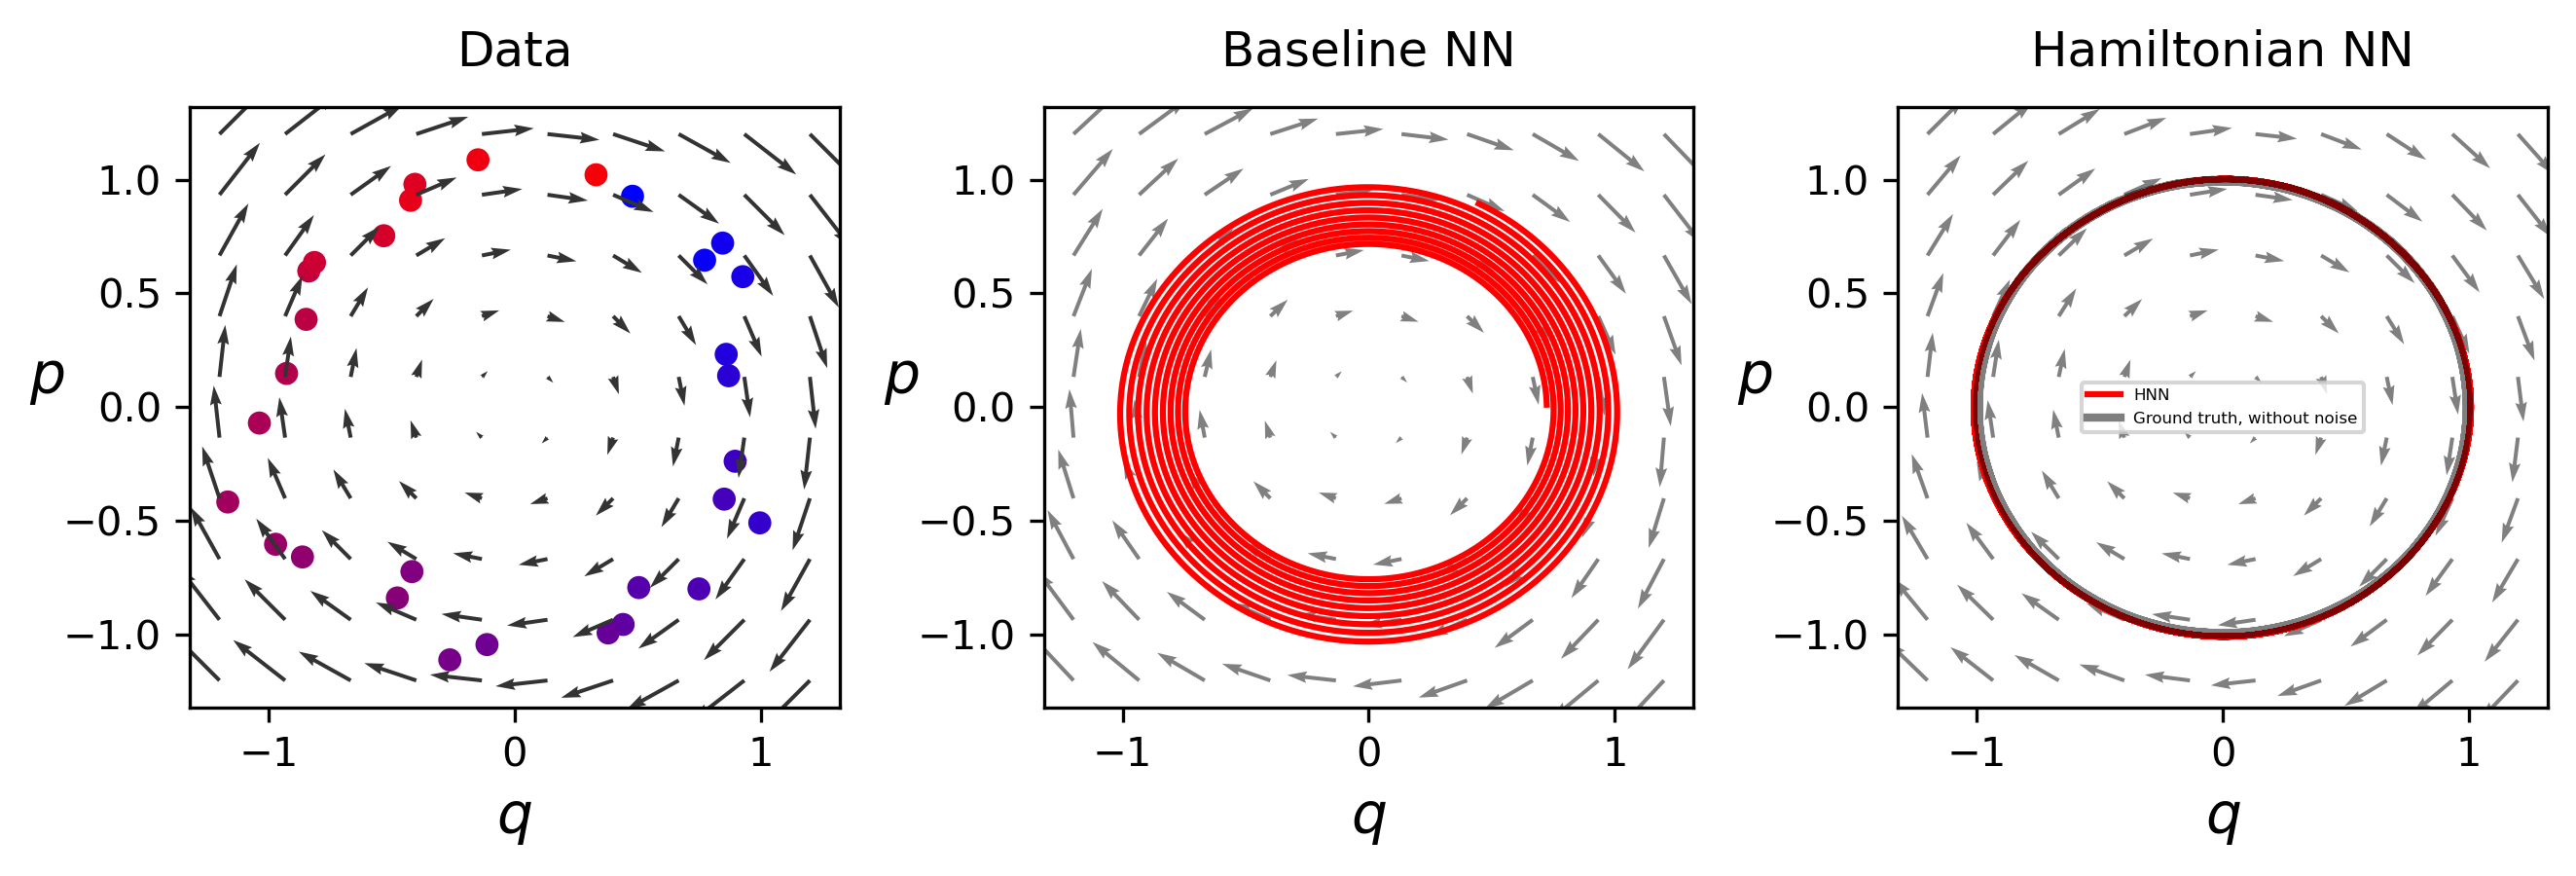

In [179]:
fig = plt.figure(figsize=(11.3, 3.1), facecolor='white', dpi=DPI)


# plot dynamics (data)
fig.add_subplot(1, 4, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(radius=1, y0=np.array([1,2]))
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=22, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot baseline
fig.add_subplot(1, 4, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))


plt.plot(base_ivp['y'][0], base_ivp['y'][1], color = 'r')
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot HNN
fig.add_subplot(1, 4, 4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

plt.plot(hnn_ivp['y'][0], hnn_ivp['y'][1], color = 'r', label = 'HNN')
    
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth, without noise', linewidth=2, alpha = 0.5)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)
plt.legend(fontsize = 4)
plt.tight_layout() ; plt.show()
#fig.savefig('{}/spring{}.{}'.format(fig_dir, RK4, FORMAT))